## Programming Exercise 3 - Multi-class Classification and Neural Networks

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# load MATLAB files
from scipy.io import loadmat
from scipy.optimize import minimize

from sklearn.linear_model import LogisticRegression

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

#### Load MATLAB datafiles

In [2]:
data = loadmat('data/ex3data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [3]:
weights = loadmat('data/ex3weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [4]:
y = data['y']
# Add constant for intercept
X = np.c_[np.ones((data['X'].shape[0],1)), data['X']]
print('X: {} (with intercept)'.format(X.shape))
print('y: {}'.format(y.shape))

X: (5000, 401) (with intercept)
y: (5000, 1)


In [5]:
theta1, theta2 = weights['Theta1'], weights['Theta2']
print('theta1: {}'.format(theta1.shape))
print('theta2: {}'.format(theta2.shape))

theta1: (25, 401)
theta2: (10, 26)


(-0.5, 399.5, 19.5, -0.5)

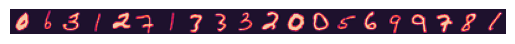

In [7]:
sample = np.random.choice(X.shape[0], 20)
plt.imshow(X[sample,1:].reshape(-1,20).T)
plt.axis('off')

### Multiclass Classification

#### Logistic regression hypothesis
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

In [8]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

#### Regularized Cost Function 
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

In [9]:
def lrcostFunctionReg(theta, reg, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    J = -1 * (1 / m) * (np.log(h).T.dot(y) + np.log(1 - h).T.dot(1 - y)) + (reg / (2 * m)) * np.sum(np.square(theta[1: ]))
    if np.isnan(J[0]):
        return (np.inf)
    return (J[0])    

In [10]:
def lrgradientReg(theta, reg, X,y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1, 1)))
    grad = (1 / m) * X.T.dot(h - y) + (reg / m) * np.r_[[[0]], theta[1:].reshape(-1, 1)]
    return (grad.flatten())

#### One-vs-all Classification

In [13]:
def oneVsAll(features, classes, n_labels, reg):
    initial_theta = np.zeros(X.shape[1])  # 401
    all_theta = np.zeros((n_labels, X.shape[1])) #10x401
    for c in np.arange(1, n_labels + 1):
        res = minimize(lrcostFunctionReg, initial_theta, args=(reg, features, (classes == c) * 1), method=None,
                       jac=lrgradientReg, options={'maxiter': 50})
        all_theta[c - 1] = res.x
    return (all_theta)

In [14]:
theta = oneVsAll(X, y, 10, 0.1)

#### One-vs-all Prediction

In [15]:
def predictOneVsAll(all_theta, features):
    probs = sigmoid(X.dot(all_theta.T))
    # Adding one because Python uses zero based indexing for the 10 columns (0-9),
    # while the 10 classes are numbered from 1 to 10.
    return(np.argmax(probs, axis=1) + 1)

In [16]:
pred = predictOneVsAll(theta, X)
print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel()) * 100))

Training set accuracy: 93.24 %


#### Multiclass Logistic Regression with scikit-learn

In [17]:
clf = LogisticRegression(C=10, penalty='l2', solver='liblinear')
# Scikit-learn fits intercept automatically, so we exclude first column with 'ones' from X when fitting.
clf.fit(X[:, 1:], y.ravel())

LogisticRegression(C=10, solver='liblinear')

In [18]:
pred2 = clf.predict(X[:, 1:])
print('Training set accuracy: {} %'.format(np.mean(pred2 == y.ravel()) * 100))

Training set accuracy: 96.5 %


### Neural Networks

In [19]:
def predict(theta_1, theta_2, features):
    z2 = theta_1.dot(features.T)
    a2 = np.c_[np.ones((data['X'].shape[0], 1)), sigmoid(z2).T]
    z3 = a2.dot(theta_2.T)
    a3 = sigmoid(z3)
    return (np.argmax(a3, axis=1) + 1) 

In [20]:
pred = predict(theta1, theta2, X)
print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel()) * 100))

Training set accuracy: 97.52 %
